# Analysis of the rent dataset

## Overview

Before we start analyzing the data and explaining our intentions, we need to get an overview of the existing data. No matter what we later want to do, we have to clean and prepocess our data in order to work with it 

### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_object_dtype
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
df = pd.read_csv("../data/testlizenz-tuebingen-dataliteracy4students_1700939273256.csv", sep=";", encoding='unicode_escape')
df.count() 

angebot_id                    16008
anz_parken                    10830
anz_zimmer                    15865
aus_alarmanlage_janein        16008
aus_bad_dusche_janein         16008
                              ...  
oeig_dachgeschoss_janein      16008
enddate                       15707
aus_balkon_terrasse_janein    16008
aus_wintergarten_janein       16008
aus_garten_eigen_janein       16008
Length: 87, dtype: int64

In [3]:
# include year column
df['year'] = df['startdate'].str[:4] 

In [4]:
df["month"] = pd.DatetimeIndex(df['startdate']).month

In [5]:
df

,angebot_id,anz_parken,anz_zimmer,aus_alarmanlage_janein,aus_bad_dusche_janein,aus_bad_gaestewc_janein,aus_bad_mit_fenster_janein,aus_bad_wanne_janein,aus_heiz_alt_erdw_janein,aus_heiz_alt_solar_janein,aus_heiz_alt_pellet_janein,aus_heiz_alt_pumpe_janein,aus_heiz_blockkw_janein,aus_heiz_befeuerung,aus_heiz_fernwaerme_janein,aus_heiz_fussboden_janein,aus_heiz_keine_janein,aus_heiz_system,aus_kamin_janein,aus_kueche_einbau_janein,aus_kueche_offen_janein,aus_kueche_pantry_janein,aus_lift_janein,aus_moebliert_janein,aus_parken_carport_janein,aus_parken_janein,aus_parken_ladestation_janein,aus_parken_stellplaetze_janein,aus_pool_janein,aus_sauna_janein,baujahr,flaeche,etage,etagen,fl_wohnen,kosten,kosten_je_flaeche,kosten_miete_gesamt_janein,kstn_betriebskosten,kstn_betriebskosten_pqm,kstn_heizung,laufzeitw_alle,laufzeitw_geschl,nachfrageart,nutzungsart,oadr_bl,oadr_gkz,oadr_kkz,kstn_nebenkosten,kstn_miete_kalt,kstn_miete_gesamt,kstn_miete_gesamt_pqm,kstn_miete_kalt_pqm,kstn_kaufpreis,kstn_kaufpreis_pqm,kstn_heizung_pqm,oadr_kreis,oadr_ort,oadr_plz,oadr_u1,oadr_u2,oadr_u3,objektart,objekttyp,objekttyp_fein,objekttyp_grob,oeig_altbau_janein,zust_saniert_janein,zust_neuwertig_janein,zust_projektiert_janein,zust_modernisierungsjahr,zust_gepflegt_janein,startdate,segment,oeig_wbs_janein,oeig_vermietet_janein,oeig_reihenendhaus_janein3,oeig_neubau_janein,oeig_loggia_janein,oeig_keller_janein,oeig_freistehend_janein,oeig_denkmal_janein,oeig_dachgeschoss_janein,enddate,aus_balkon_terrasse_janein,aus_wintergarten_janein,aus_garten_eigen_janein,year,month
0,3594713336,NaN,"2,",0,1,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,1,1,0,0,0,0,0,0,0,0,0,NaN,"55,","0,",NaN,"55,","950,","17,27",1,NaN,NaN,NaN,",1",NaN,miete,Wohn,8,8416041,8416,NaN,NaN,"950,","17,27",NaN,NaN,NaN,NaN,Tübingen,Tübingen,72070,NaN,NaN,NaN,Einheit,Wohnung,2-Z-Whg,Wohnung,1,0,0,0,NaN,0,2023-11-15,NaN,0,0,0,0,0,0,0,0,-1,NaN,1,0,-1,2023,11
1,3594016393,NaN,"2,",0,1,0,0,0,0,0,0,0,0,Gas,0,0,0,NaN,0,1,0,0,1,0,0,0,0,0,0,0,1980.0,"50,","0,","3,","50,","750,","15,",0,NaN,NaN,NaN,",1",NaN,miete,Wohn,8,8416041,8416,"120,","750,","870,","17,4","15,",NaN,NaN,NaN,Tübingen,Tübingen,72070,Tübingen,Universität,NaN,Einheit,Wohnung,2-Z-Whg,Wohnung,0,1,0,0,2023.0,0,2023-11-15,WHG_M,0,0,0,0,0,1,0,0,-1,NaN,0,0,0,2023,11
2,3593975043,NaN,"1,",0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1984.0,"40,","0,",NaN,"40,","400,","10,",0,NaN,NaN,NaN,",1",NaN,miete,Wohn,8,8416041,8416,"40,","400,","440,","11,","10,",NaN,NaN,NaN,Tübingen,Tübingen,72076,Tübingen,Schönblick/Waldhäuser Ost,NaN,Einheit,Wohnung,1-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-11-15,WHG_M,0,0,0,0,0,0,0,0,-1,NaN,1,0,0,2023,11
3,3594255459,1.0,"3,",0,1,1,0,1,0,0,0,0,0,NaN,1,0,0,Zentral,0,0,0,0,1,0,0,1,0,0,0,0,2011.0,"109,58","3,",NaN,"109,58","1750,","15,97",0,NaN,NaN,NaN,",2",NaN,miete,Wohn,8,8416041,8416,"300,","1750,","2050,","18,71","15,97",NaN,NaN,NaN,Tübingen,Tübingen,72074,Tübingen,Zentrum,NaN,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,0,0,NaN,1,2023-11-14,WHG_M,0,0,0,0,0,1,0,-1,0,NaN,1,0,0,2023,11
4,3594061704,1.0,"3,",0,0,0,0,1,0,0,0,0,0,Öl,0,0,0,NaN,0,1,0,0,0,0,0,1,0,0,0,0,1985.0,"96,","1,",NaN,"96,","345000,","3593,75",0,"20,",",21",NaN,",2",NaN,kauf,Wohn,8,8416041,8416,NaN,NaN,NaN,NaN,NaN,"345000,","3593,75",NaN,Tübingen,Tübingen,72072,Bühl,Bühl,NaN,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-11-14,WHG_K,0,0,0,0,0,1,0,0,0,NaN,1,0,1,2023,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16003,3041045247,NaN,"2,5",0,1,0,1,1,0,0,0,0,0,Gas,0,0,0,Zentral,0,0,0,0,0,0,0,0,0,0,0,0,NaN,"104,",NaN,NaN,"104,","825,","7,93",0,NaN,NaN,NaN,"186,9","186,9",miete,Wohn,8,8416041,8416,"260,","825,","1085,","10,43","7,93",NaN,NaN,NaN,Tübingen,T

### How many houses and flats are in the dataset?

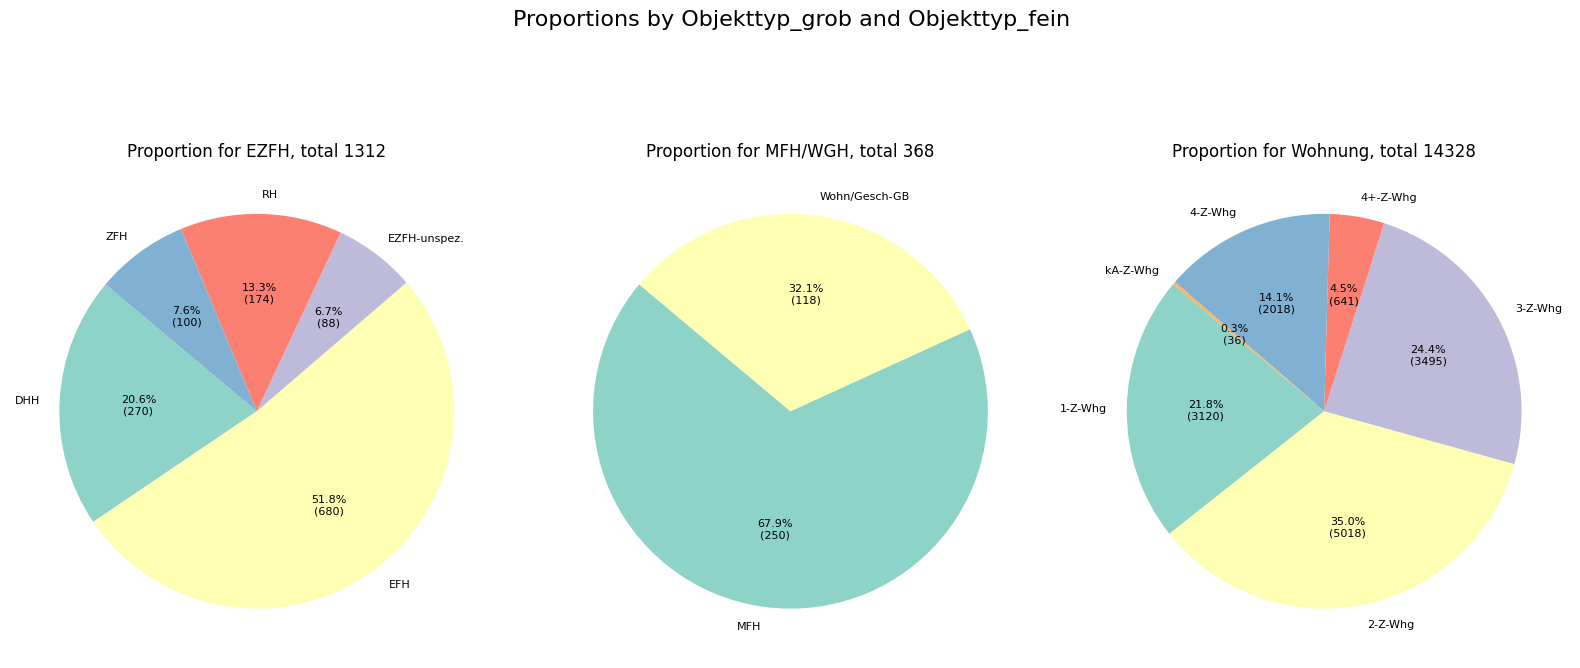

In [6]:
grouped_df = df.groupby(["objekttyp_grob", "objekttyp_fein"]).size().reset_index(name='count')
unique_grobs = grouped_df['objekttyp_grob'].unique()
fig, axes = plt.subplots(1, len(unique_grobs), figsize=(16, 8), subplot_kw=dict(aspect="equal"))
subtitle_text = ""
colors = plt.cm.Set3.colors  # Set color palette, adjust as needed

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"


for i, (grob, ax) in enumerate(zip(unique_grobs, axes.flatten())):
    grob_df = grouped_df[grouped_df['objekttyp_grob'] == grob]
    wedges, texts, autotexts = ax.pie(grob_df['count'], labels=grob_df['objekttyp_fein'], autopct=lambda pct: func(pct, grob_df['count']),
                                      colors=colors, startangle=140)
    ax.set_title(f'Proportion for {grob}, total {grob_df["count"].sum()}')
    
    # Increase the size of the labels and percentage values for better visibility
    for text in texts + autotexts:
        text.set_fontsize(8)
    # subtitle_text += f"Total for {grob}: {grob_df['count'].sum()} \n \n"
    
fig.suptitle(f'{subtitle_text}\n', fontsize=16, style='italic')
fig.suptitle('Proportions by Objekttyp_grob and Objekttyp_fein', fontsize=16)
fig.tight_layout()
plt.show()

#### We can clearly see that there are far more flats than houses.

### How many of those flats and houses are for sail, how many for rent?

In [7]:
df.groupby(["objekttyp_grob", "nachfrageart"]).size().reset_index(name='count')

,objekttyp_grob,nachfrageart,count
0,EZFH,kauf,1032
1,EZFH,miete,280
2,MFH/WGH,kauf,368
3,Wohnung,kauf,3754
4,Wohnung,miete,10574


-------------

# Where are those flats and houses located?
Now that we have generated a quick overview about our data, we will now focus on where these flats and houses actually are. We want to identify the region in Tübingen that has the most offers. Once we have categorized the data by region, we will also look at the price distribution in each region to compare the prices but simultaneously the regions.  

## Cleaning process..

*With which loaction do we start?*
Given are two different location attributes, *oadr_u2* being more specific than *oadr_u1*.

In [8]:
df_total_oadr_u1 = df.groupby(["oadr_u1"]).size().reset_index(name='count')
df_total_oadr_u1_count = df["oadr_u1"].isnull().sum()
print(f"Total number of OADR_U1: {df_total_oadr_u1['count'].sum()}")
print(f"Total number of OADR_U1 with no value: {df_total_oadr_u1_count}")
df.groupby(["oadr_u1"]).size().reset_index(name='count')

Total number of OADR_U1: 11927
Total number of OADR_U1 with no value: 4081


,oadr_u1,count
0,Bebenhausen,63
1,Bühl,403
2,Derendingen,870
3,Hagelloch,182
4,Hirschau,472
5,Kilchberg,138
6,Lustnau,1456
7,Pfrondorf,420
8,Tübingen,7456
9,Unterjesingen,329


In [9]:
df_total_oadr_u2 = df.groupby(["oadr_u2"]).size().reset_index(name='count')
df_total_oadr_u2_count = df["oadr_u2"].isnull().sum()
print(f"Total number of OADR_U2: {df_total_oadr_u2['count'].sum()}")
print(f"Total number of OADR_U2 with no value: {df_total_oadr_u2_count}")
df.groupby(["oadr_u2"]).size().reset_index(name='count')

Total number of OADR_U2: 9131
Total number of OADR_U2 with no value: 6877


,oadr_u2,count
0,Aeule,76
1,Au/Unterer Wert/Französiches Viertel,481
2,Bebenhausen,63
3,Bühl,403
4,De-Zentrum,90
5,Denzenberg/Sand,191
6,Feuerhägle/Mühlenviertel,269
7,Gartenstadt,26
8,Hagelloch,182
9,Hirschau,472


In [10]:
df[df["oadr_u2"].isna()].groupby(["oadr_u1"]).size().reset_index(name='count')

,oadr_u1,count
0,Derendingen,485
1,Lustnau,675
2,Tübingen,1636


In [11]:
df[df["oadr_u1"].isna()].groupby(["oadr_u2"]).size().reset_index(name='count')

,oadr_u2,count


In [12]:
df.groupby(["oadr_u2", "oadr_u1"]).size().reset_index(name='count').sort_values(by=['oadr_u1'], ascending=False)

,oadr_u2,oadr_u1,count
19,Weilheim,Weilheim,138
17,Unterjesingen,Unterjesingen,329
22,Österberg/Gartenstraße,Tübingen,207
21,Zentrum,Tübingen,727
20,Weststadt,Tübingen,1053
18,Wanne,Tübingen,661
16,Universität,Tübingen,1030
15,Südstadt,Tübingen,1047
14,Schönblick/Waldhäuser Ost,Tübingen,614
1,Au/Unterer Wert/Französiches Viertel,Tübingen,481


In [13]:
oadr_u2 = df["oadr_u2"].unique().tolist()
cleaned_oadr_2 = [x for x in oadr_u2 if x == x]
cleaned_oadr_2

['Universität',
 'Schönblick/Waldhäuser Ost',
 'Zentrum',
 'Bühl',
 'Südstadt',
 'Hagelloch',
 'Kilchberg',
 'Au/Unterer Wert/Französiches Viertel',
 'Weststadt',
 'Bebenhausen',
 'Hirschau',
 'Österberg/Gartenstraße',
 'Pfrondorf',
 'Wanne',
 'Unterjesingen',
 'Feuerhägle/Mühlenviertel',
 'Lustnau-Zentrum/Herrlesberg/Stäudach',
 'De-Zentrum',
 'Aeule',
 'Weilheim',
 'Denzenberg/Sand',
 'Gartenstadt',
 'Neuhalde']

For the further approach, knowing where the houses are is important. Therefore we will now clean the data and remove all entries that do not have a location attribute.

In [14]:
df_w_loc = df[df['oadr_u1'].notna()]
df_wo_loc = df[df['oadr_u1'].isna()]
print(f"Total number of rows with location: {df_w_loc.shape[0]}")
print(f"Total number of rows without location: {df_wo_loc.shape[0]}")

Total number of rows with location: 11927
Total number of rows without location: 4081


### Adjusting entries
From previous analysis I know that the integer and float values in the dataset are kind of messy, pandas cant interpret them as actual values because they are seperated with **`,`** instead of **`.`** Lets fix this.

In [15]:
df_w_loc

,angebot_id,anz_parken,anz_zimmer,aus_alarmanlage_janein,aus_bad_dusche_janein,aus_bad_gaestewc_janein,aus_bad_mit_fenster_janein,aus_bad_wanne_janein,aus_heiz_alt_erdw_janein,aus_heiz_alt_solar_janein,aus_heiz_alt_pellet_janein,aus_heiz_alt_pumpe_janein,aus_heiz_blockkw_janein,aus_heiz_befeuerung,aus_heiz_fernwaerme_janein,aus_heiz_fussboden_janein,aus_heiz_keine_janein,aus_heiz_system,aus_kamin_janein,aus_kueche_einbau_janein,aus_kueche_offen_janein,aus_kueche_pantry_janein,aus_lift_janein,aus_moebliert_janein,aus_parken_carport_janein,aus_parken_janein,aus_parken_ladestation_janein,aus_parken_stellplaetze_janein,aus_pool_janein,aus_sauna_janein,baujahr,flaeche,etage,etagen,fl_wohnen,kosten,kosten_je_flaeche,kosten_miete_gesamt_janein,kstn_betriebskosten,kstn_betriebskosten_pqm,kstn_heizung,laufzeitw_alle,laufzeitw_geschl,nachfrageart,nutzungsart,oadr_bl,oadr_gkz,oadr_kkz,kstn_nebenkosten,kstn_miete_kalt,kstn_miete_gesamt,kstn_miete_gesamt_pqm,kstn_miete_kalt_pqm,kstn_kaufpreis,kstn_kaufpreis_pqm,kstn_heizung_pqm,oadr_kreis,oadr_ort,oadr_plz,oadr_u1,oadr_u2,oadr_u3,objektart,objekttyp,objekttyp_fein,objekttyp_grob,oeig_altbau_janein,zust_saniert_janein,zust_neuwertig_janein,zust_projektiert_janein,zust_modernisierungsjahr,zust_gepflegt_janein,startdate,segment,oeig_wbs_janein,oeig_vermietet_janein,oeig_reihenendhaus_janein3,oeig_neubau_janein,oeig_loggia_janein,oeig_keller_janein,oeig_freistehend_janein,oeig_denkmal_janein,oeig_dachgeschoss_janein,enddate,aus_balkon_terrasse_janein,aus_wintergarten_janein,aus_garten_eigen_janein,year,month
1,3594016393,NaN,"2,",0,1,0,0,0,0,0,0,0,0,Gas,0,0,0,NaN,0,1,0,0,1,0,0,0,0,0,0,0,1980.0,"50,","0,","3,","50,","750,","15,",0,NaN,NaN,NaN,",1",NaN,miete,Wohn,8,8416041,8416,"120,","750,","870,","17,4","15,",NaN,NaN,NaN,Tübingen,Tübingen,72070,Tübingen,Universität,NaN,Einheit,Wohnung,2-Z-Whg,Wohnung,0,1,0,0,2023.0,0,2023-11-15,WHG_M,0,0,0,0,0,1,0,0,-1,NaN,0,0,0,2023,11
2,3593975043,NaN,"1,",0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1984.0,"40,","0,",NaN,"40,","400,","10,",0,NaN,NaN,NaN,",1",NaN,miete,Wohn,8,8416041,8416,"40,","400,","440,","11,","10,",NaN,NaN,NaN,Tübingen,Tübingen,72076,Tübingen,Schönblick/Waldhäuser Ost,NaN,Einheit,Wohnung,1-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-11-15,WHG_M,0,0,0,0,0,0,0,0,-1,NaN,1,0,0,2023,11
3,3594255459,1.0,"3,",0,1,1,0,1,0,0,0,0,0,NaN,1,0,0,Zentral,0,0,0,0,1,0,0,1,0,0,0,0,2011.0,"109,58","3,",NaN,"109,58","1750,","15,97",0,NaN,NaN,NaN,",2",NaN,miete,Wohn,8,8416041,8416,"300,","1750,","2050,","18,71","15,97",NaN,NaN,NaN,Tübingen,Tübingen,72074,Tübingen,Zentrum,NaN,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,0,0,NaN,1,2023-11-14,WHG_M,0,0,0,0,0,1,0,-1,0,NaN,1,0,0,2023,11
4,3594061704,1.0,"3,",0,0,0,0,1,0,0,0,0,0,Öl,0,0,0,NaN,0,1,0,0,0,0,0,1,0,0,0,0,1985.0,"96,","1,",NaN,"96,","345000,","3593,75",0,"20,",",21",NaN,",2",NaN,kauf,Wohn,8,8416041,8416,NaN,NaN,NaN,NaN,NaN,"345000,","3593,75",NaN,Tübingen,Tübingen,72072,Bühl,Bühl,NaN,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-11-14,WHG_K,0,0,0,0,0,1,0,0,0,NaN,1,0,1,2023,11
5,3593974527,2.0,"2,5",0,0,0,0,1,0,0,0,0,0,Gas,0,0,0,NaN,0,1,0,0,0,1,0,1,0,1,0,0,1989.0,"65,47","0,",NaN,"65,47","299000,","4566,98",0,NaN,NaN,NaN,",1",NaN,kauf,Wohn,8,8416041,8416,NaN,NaN,NaN,NaN,NaN,"299000,","4566,98",NaN,Tübingen,Tübingen,72072,Tübingen,Südstadt,NaN,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,0,0,NaN,1,2023-11-14,WHG_K,0,0,0,0,0,1,0,0,-1,NaN,1,0,0,2023,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15998,27439257,1.0,"5,",0,1,1,0,1,0,0,0,0,0,Gas,0,1,0,NaN,0,0,0,0,1,0,0,1,0,0,0,0,2011.0,"168,7","5,","6,","168,7","619000,","3669,24",0,NaN,NaN,NaN,"48,5","48,5",kauf,Wohn,8,8416041,8416,NaN,NaN,NaN,NaN,NaN,"619000,

In [16]:
df_w_loc["fl_wohnen"].dtype

dtype('O')

In [17]:
for column in df.columns:
    if is_object_dtype(df[column]):
        if df[column].str.contains(',').any(): 
            df[column] = df[column].str.replace(',', '.').astype(float)
            df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
df_w_loc

/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3736/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3736/1307623920.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w_loc[column] = df_w_loc[column].str.replace(',', '.').astype(float)
/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_3736/1307623920.py:5: SettingWithCopyWarning: 
A value 

,angebot_id,anz_parken,anz_zimmer,aus_alarmanlage_janein,aus_bad_dusche_janein,aus_bad_gaestewc_janein,aus_bad_mit_fenster_janein,aus_bad_wanne_janein,aus_heiz_alt_erdw_janein,aus_heiz_alt_solar_janein,aus_heiz_alt_pellet_janein,aus_heiz_alt_pumpe_janein,aus_heiz_blockkw_janein,aus_heiz_befeuerung,aus_heiz_fernwaerme_janein,aus_heiz_fussboden_janein,aus_heiz_keine_janein,aus_heiz_system,aus_kamin_janein,aus_kueche_einbau_janein,aus_kueche_offen_janein,aus_kueche_pantry_janein,aus_lift_janein,aus_moebliert_janein,aus_parken_carport_janein,aus_parken_janein,aus_parken_ladestation_janein,aus_parken_stellplaetze_janein,aus_pool_janein,aus_sauna_janein,baujahr,flaeche,etage,etagen,fl_wohnen,kosten,kosten_je_flaeche,kosten_miete_gesamt_janein,kstn_betriebskosten,kstn_betriebskosten_pqm,kstn_heizung,laufzeitw_alle,laufzeitw_geschl,nachfrageart,nutzungsart,oadr_bl,oadr_gkz,oadr_kkz,kstn_nebenkosten,kstn_miete_kalt,kstn_miete_gesamt,kstn_miete_gesamt_pqm,kstn_miete_kalt_pqm,kstn_kaufpreis,kstn_kaufpreis_pqm,kstn_heizung_pqm,oadr_kreis,oadr_ort,oadr_plz,oadr_u1,oadr_u2,oadr_u3,objektart,objekttyp,objekttyp_fein,objekttyp_grob,oeig_altbau_janein,zust_saniert_janein,zust_neuwertig_janein,zust_projektiert_janein,zust_modernisierungsjahr,zust_gepflegt_janein,startdate,segment,oeig_wbs_janein,oeig_vermietet_janein,oeig_reihenendhaus_janein3,oeig_neubau_janein,oeig_loggia_janein,oeig_keller_janein,oeig_freistehend_janein,oeig_denkmal_janein,oeig_dachgeschoss_janein,enddate,aus_balkon_terrasse_janein,aus_wintergarten_janein,aus_garten_eigen_janein,year,month
1,3594016393,NaN,2.0,0,1,0,0,0,0,0,0,0,0,Gas,0,0,0,NaN,0,1,0,0,1,0,0,0,0,0,0,0,1980.0,50.00,0.0,3.0,50.00,750.0,15.00,0,NaN,NaN,NaN,0.1,NaN,miete,Wohn,8,8416041,8416,120.0,750.0,870.0,17.40,15.00,NaN,NaN,NaN,Tübingen,Tübingen,72070,Tübingen,Universität,NaN,Einheit,Wohnung,2-Z-Whg,Wohnung,0,1,0,0,2023.0,0,2023-11-15,WHG_M,0,0,0,0,0,1,0,0,-1,NaN,0,0,0,2023,11
2,3593975043,NaN,1.0,0,0,0,0,0,0,0,0,0,0,NaN,0,0,0,NaN,0,1,0,0,0,0,0,0,0,0,0,0,1984.0,40.00,0.0,NaN,40.00,400.0,10.00,0,NaN,NaN,NaN,0.1,NaN,miete,Wohn,8,8416041,8416,40.0,400.0,440.0,11.00,10.00,NaN,NaN,NaN,Tübingen,Tübingen,72076,Tübingen,Schönblick/Waldhäuser Ost,NaN,Einheit,Wohnung,1-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-11-15,WHG_M,0,0,0,0,0,0,0,0,-1,NaN,1,0,0,2023,11
3,3594255459,1.0,3.0,0,1,1,0,1,0,0,0,0,0,NaN,1,0,0,Zentral,0,0,0,0,1,0,0,1,0,0,0,0,2011.0,109.58,3.0,NaN,109.58,1750.0,15.97,0,NaN,NaN,NaN,0.2,NaN,miete,Wohn,8,8416041,8416,300.0,1750.0,2050.0,18.71,15.97,NaN,NaN,NaN,Tübingen,Tübingen,72074,Tübingen,Zentrum,NaN,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,0,0,NaN,1,2023-11-14,WHG_M,0,0,0,0,0,1,0,-1,0,NaN,1,0,0,2023,11
4,3594061704,1.0,3.0,0,0,0,0,1,0,0,0,0,0,Öl,0,0,0,NaN,0,1,0,0,0,0,0,1,0,0,0,0,1985.0,96.00,1.0,NaN,96.00,345000.0,3593.75,0,20.0,0.21,NaN,0.2,NaN,kauf,Wohn,8,8416041,8416,NaN,NaN,NaN,NaN,NaN,345000.0,3593.75,NaN,Tübingen,Tübingen,72072,Bühl,Bühl,NaN,Einheit,Wohnung,3-Z-Whg,Wohnung,0,0,0,0,NaN,0,2023-11-14,WHG_K,0,0,0,0,0,1,0,0,0,NaN,1,0,1,2023,11
5,3593974527,2.0,2.5,0,0,0,0,1,0,0,0,0,0,Gas,0,0,0,NaN,0,1,0,0,0,1,0,1,0,1,0,0,1989.0,65.47,0.0,NaN,65.47,299000.0,4566.98,0,NaN,NaN,NaN,0.1,NaN,kauf,Wohn,8,8416041,8416,NaN,NaN,NaN,NaN,NaN,299000.0,4566.98,NaN,Tübingen,Tübingen,72072,Tübingen,Südstadt,NaN,Einheit,Wohnung,2-Z-Whg,Wohnung,0,0,0,0,NaN,1,2023-11-14,WHG_K,0,0,0,0,0,1,0,0,-1,NaN,1,0,0,2023,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15998,27439257,1.0,5.0,0,1,1,0,1,0,0,0,0,0,Gas,0,1,0,NaN,0,0,0,0,1,0,0,1,0,0,0,0,2011.0,168.70,5.0,6.0,168.70,619000.0,3669.24,0,NaN,NaN,NaN,48.5,48.5,kauf,Wohn,8,8416041,8416,NaN,NaN,NaN,NaN,NaN,619000.0,3669.24,NaN,Tübingen,Tübingen,72070,Tübingen,Zentrum,NaN,Einheit,Wohn

In [18]:
df_w_loc.shape[0]

11927

## Now that we have cleaned our data, lets look at the regions

In [19]:
df_w_loc.groupby(["oadr_u1"]).size().reset_index(name='count')

,oadr_u1,count
0,Bebenhausen,63
1,Bühl,403
2,Derendingen,870
3,Hagelloch,182
4,Hirschau,472
5,Kilchberg,138
6,Lustnau,1456
7,Pfrondorf,420
8,Tübingen,7456
9,Unterjesingen,329


## Display them in a map
We are going to display a map of Tübingen where we will mark the locations of the flats and houses. The color of the marker will represent the price of the flat/house. The darker the marker, the higher the price. 

In [20]:
import geopandas as gpd

path_tue_shp = '../data/KLGL_Stadtteile_Shape/KLGL_Stadtteile_Shape.shp'
tuebingen_gdf = gpd.read_file('../data/KLGL_Stadtteile_Shape/KLGL_Stadtteile_Shape.shp')


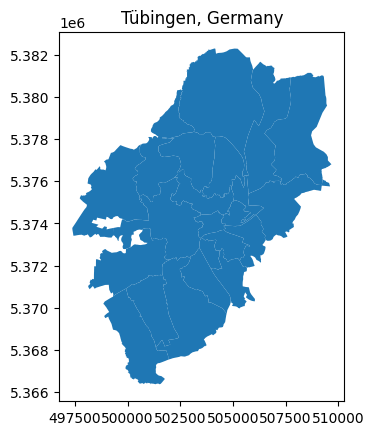

In [21]:
tuebingen_gdf.plot()
plt.title('Tübingen, Germany')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


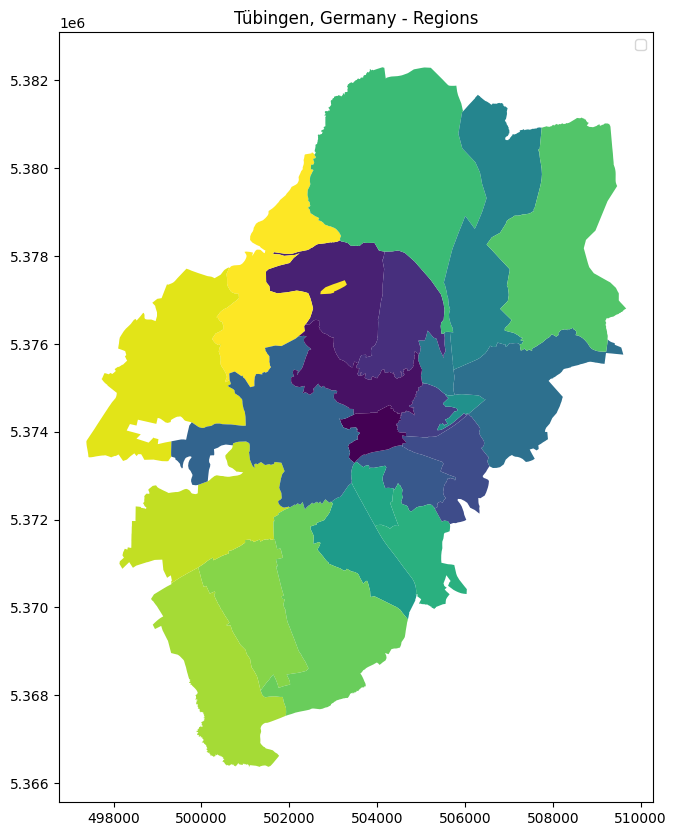

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf.plot(ax=ax, cmap='viridis', edgecolor=None, legend=True, column='STT')

# Add labels and legend
plt.title('Tübingen, Germany - Regions')
plt.legend()

# Show the plot
plt.show()


### Issue we faced
We have no labels in the polygons, which makes it hard to identify the regions

#### Solution: Assign random labels to see which polygon corresponds to which region

['kz', '6y', 'zk', 'x6', 'be', 'ur', '4u', 'fo', 'h1', '6x', '4k', '4i', 'jf', '29', 'v3', 'kk', 'w4', 'g7', 'ny', 'fn', 'un', 'gb', '4n']


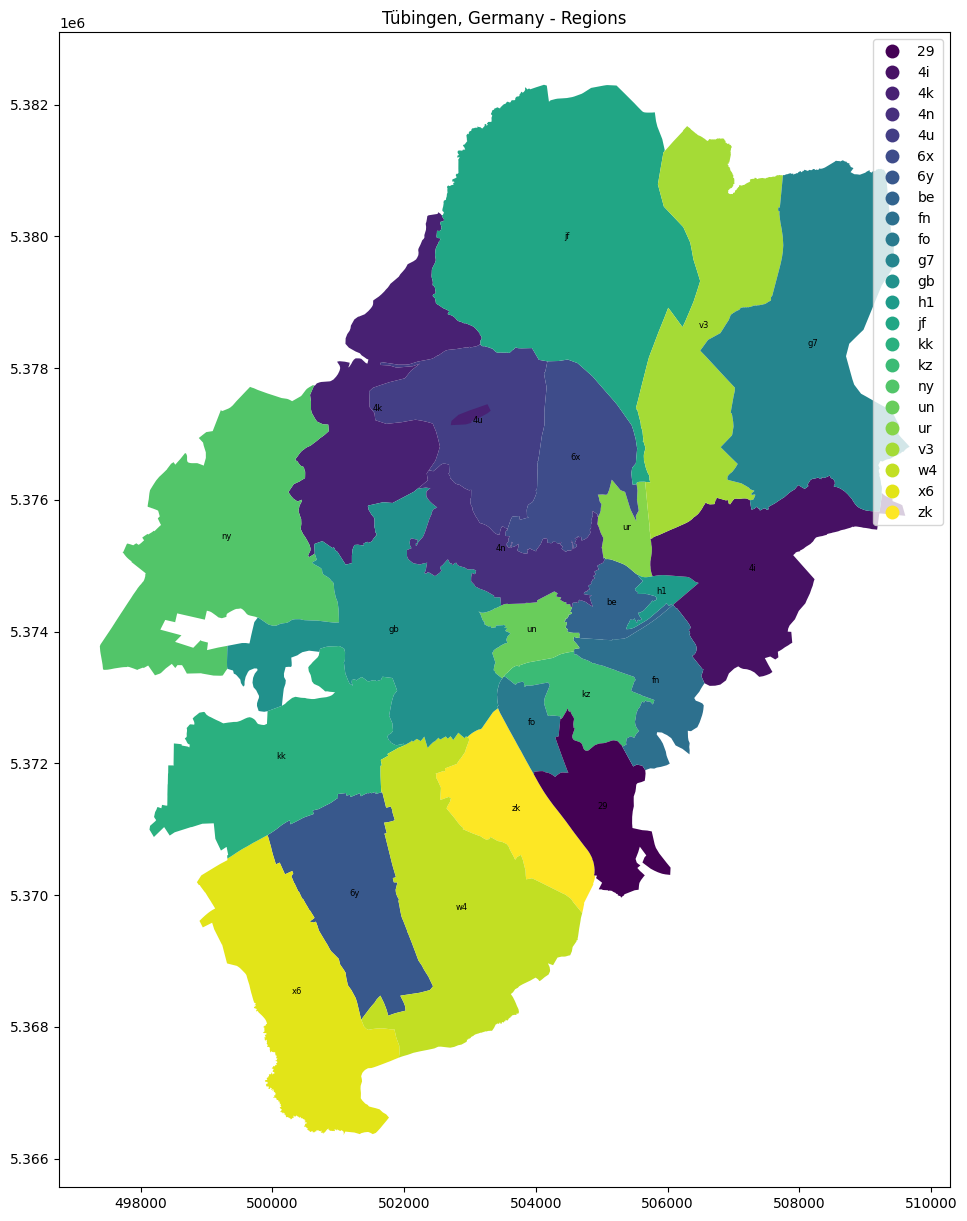

In [23]:
from random import choice
from string import ascii_lowercase, digits

chars = ascii_lowercase + digits
lst = [''.join(choice(chars) for _ in range(2)) for _ in range(23)]
print(lst)
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = lst
# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(20, 15))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf.plot(ax=ax, cmap='viridis', edgecolor=None, legend=True,  column="region",)
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions')

# Show the plot
plt.show()


## Map regions now with OADR-U2

In [24]:
shp_dict = {'Universität':22,
 'Schönblick/Waldhäuser Ost':9,
 'Zentrum':20,
 'Bühl': 3,
 'Südstadt': 0,
 'Hagelloch': 10,
 'Kilchberg': 1,
 'Au/Unterer Wert/Französiches Viertel':19,
 'Weststadt':21,
 'Bebenhausen':12,
 'Hirschau':15,
 'Österberg/Gartenstraße':4,
 'Pfrondorf':17,
 'Wanne': 6,
 'Unterjesingen':18,
 'Feuerhägle/Mühlenviertel':7,
 'Lustnau-Zentrum/Herrlesberg/Stäudach':11,
 'De-Zentrum': 2,
 'Aeule':8,
 'Weilheim':16,
 'Denzenberg/Sand': 5,
 'Gartenstadt':13,
 'Neuhalde':14 }
sorted_dict = dict(sorted(shp_dict.items(), key=lambda item: item[1]))
sorted_dict

{'Südstadt': 0,
 'Kilchberg': 1,
 'De-Zentrum': 2,
 'Bühl': 3,
 'Österberg/Gartenstraße': 4,
 'Denzenberg/Sand': 5,
 'Wanne': 6,
 'Feuerhägle/Mühlenviertel': 7,
 'Aeule': 8,
 'Schönblick/Waldhäuser Ost': 9,
 'Hagelloch': 10,
 'Lustnau-Zentrum/Herrlesberg/Stäudach': 11,
 'Bebenhausen': 12,
 'Gartenstadt': 13,
 'Neuhalde': 14,
 'Hirschau': 15,
 'Weilheim': 16,
 'Pfrondorf': 17,
 'Unterjesingen': 18,
 'Au/Unterer Wert/Französiches Viertel': 19,
 'Zentrum': 20,
 'Weststadt': 21,
 'Universität': 22}

In [25]:
res = dict((v,k) for k,v in shp_dict.items()) # just swaps the keys and values

In [26]:
df.groupby(['oadr_u1'])['oadr_u2'].apply(lambda grp: list(grp.value_counts().index)).to_dict() # could be useful maybe 

{'Bebenhausen': ['Bebenhausen'],
 'Bühl': ['Bühl'],
 'Derendingen': ['Feuerhägle/Mühlenviertel', 'De-Zentrum', 'Gartenstadt'],
 'Hagelloch': ['Hagelloch'],
 'Hirschau': ['Hirschau'],
 'Kilchberg': ['Kilchberg'],
 'Lustnau': ['Lustnau-Zentrum/Herrlesberg/Stäudach',
  'Denzenberg/Sand',
  'Neuhalde',
  'Aeule'],
 'Pfrondorf': ['Pfrondorf'],
 'Tübingen': ['Weststadt',
  'Südstadt',
  'Universität',
  'Zentrum',
  'Wanne',
  'Schönblick/Waldhäuser Ost',
  'Au/Unterer Wert/Französiches Viertel',
  'Österberg/Gartenstraße'],
 'Unterjesingen': ['Unterjesingen'],
 'Weilheim': ['Weilheim']}

### Plot the map with the right regions

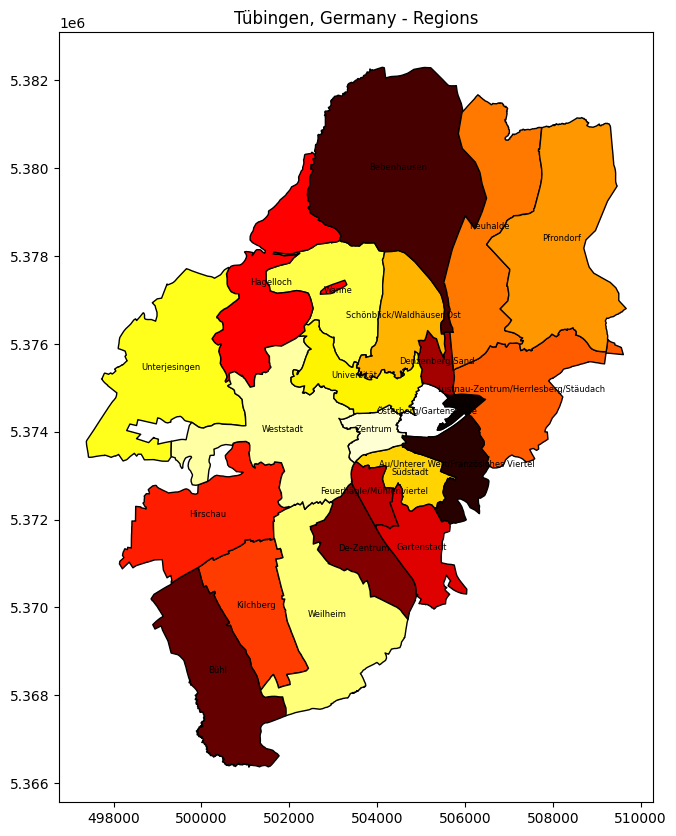

In [27]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = sorted_dict.keys()

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf.plot(ax=ax, cmap='hot', edgecolor='black', column="region",)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions')

# Show the plot
plt.show()


### Generate random column with value representing the density and plot it

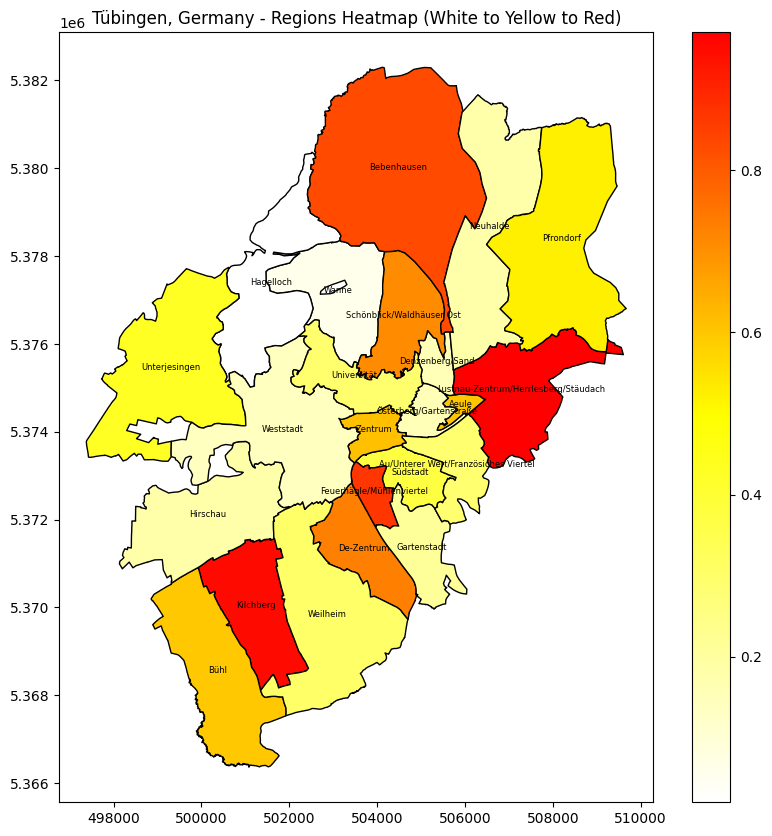

In [28]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf = gpd.read_file(path_tue_shp)

# Assign random density values to each region for demonstration purposes
np.random.seed(42)  # Set a seed for reproducibility
tuebingen_gdf["density"] = np.random.rand(len(tuebingen_gdf))
tuebingen_gdf["region"] = sorted_dict.keys()
# Define a custom colormap from white to yellow to red
colors = [(1, 1, 1), (1, 1, 0), (1, 0, 0)]  # White to yellow to red
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="density", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

# Show the plot
plt.show()


# Density plot
## The more flats in one area, the darker the color

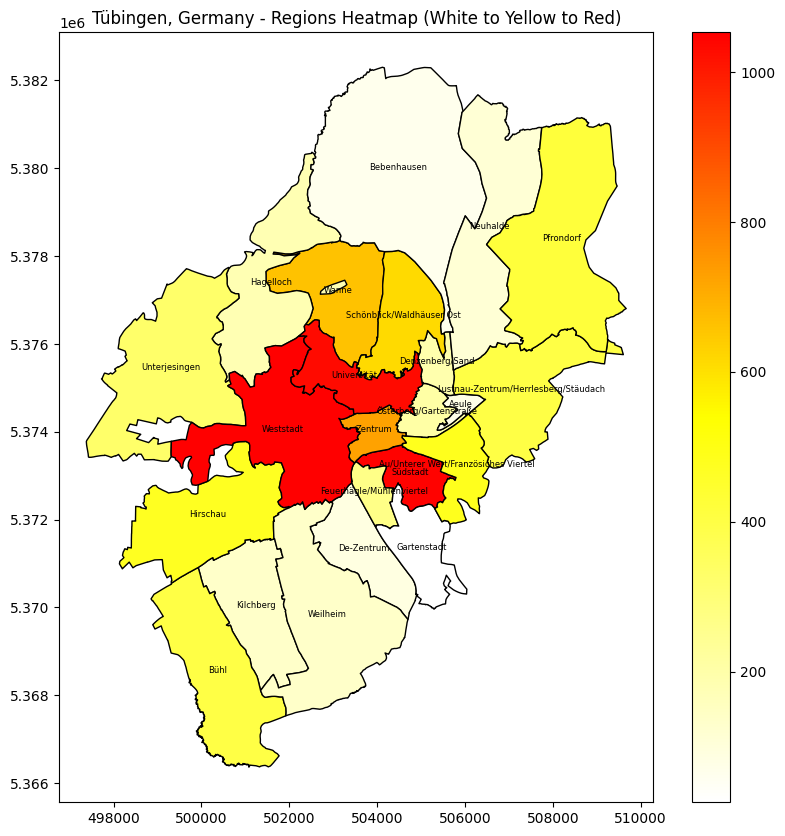

In [29]:
df_grouped = df_w_loc.groupby(["oadr_u2"]).size().reset_index(name='number_elements')
tuebingen_gdf = gpd.read_file(path_tue_shp)
tuebingen_gdf["region"] = sorted_dict.keys()
tuebingen_gdf = tuebingen_gdf.join(df_grouped.set_index("oadr_u2"), on="region")
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column="number_elements", legend=True)

# Add labels for each region
for idx, row in tuebingen_gdf.iterrows():
    plt.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Add labels and legend
plt.title('Tübingen, Germany - Regions Heatmap (White to Yellow to Red)')

# Show the plot
plt.show()



## ToDo Now

- [ ] Heatmap to usefull test statistics, like median or average rent
- [ ] maybe beautify heatmap aswell
- [ ] also maybe take ration into account, [Bevölkerung](https://www.tuebingen.de/Dateien/einwohner_stadtteile_Jahresvergleich.pdf) 

After that, one is going to ask - why is the mean renting price so much higher there, and then we look at the distribution of the prices in each region and find answers to that!
<br>
Maybe it is because of the way the flats are there(small flats only)

# Verlauf von den Mietpeisen in dne jeweiligen Regionen

### 1)
- wie viel Kaufeinträge haben wir pro stadtteil (links)
- wie viel Mieteinträge haben wir pro stadtteil (rechts)

### 2)
- Average Miete/Median Miete in den jeweiligen Stadtteilen
- Verlauf von Mietpreisen/Kauforeisen, Berechnung von slope (heatmap, je roter desto steiler slope), linear regression, etc.

### 3)
- ratio von Einträgen/Bewohner

### 4) 
- Generell welche Art von Wohnung ist wo, finde ich eine 4-Zimmer Wohnung in Lustnau? 
- wie viel Zimmer pro Stadtteil, wiviel Quadratmeter pro Stadtteil

## Make use of map, you know the situation, now make use and sense of it
- trends, surprises, explanations
- you finish abitur and wnat to look for a place to live with your 4 friends, where do you look?

-----------


## Kaufeinträge pro Stadtteil

In [30]:
# Kaufeinträge
df_w_loc.groupby(["oadr_u2", "nachfrageart"]).size().reset_index(name='count')

,oadr_u2,nachfrageart,count
0,Aeule,kauf,26
1,Aeule,miete,50
2,Au/Unterer Wert/Französiches Viertel,kauf,90
3,Au/Unterer Wert/Französiches Viertel,miete,391
4,Bebenhausen,kauf,19
5,Bebenhausen,miete,44
6,Bühl,kauf,176
7,Bühl,miete,227
8,De-Zentrum,kauf,20
9,De-Zentrum,miete,70


In [31]:
df_kauf = df_w_loc[df_w_loc["nachfrageart"] == "kauf"].groupby(["oadr_u2"]).size().reset_index(name='count_kauf')
df_miete = df_w_loc[df_w_loc["nachfrageart"] == "miete"].groupby(["oadr_u2"]).size().reset_index(name='count_miete')

In [32]:
df_kauf

,oadr_u2,count_kauf
0,Aeule,26
1,Au/Unterer Wert/Französiches Viertel,90
2,Bebenhausen,19
3,Bühl,176
4,De-Zentrum,20
5,Denzenberg/Sand,45
6,Feuerhägle/Mühlenviertel,55
7,Gartenstadt,8
8,Hagelloch,45
9,Hirschau,158


In [33]:
tuebingen_gdf = tuebingen_gdf.join(df_kauf.set_index("oadr_u2"), on="region")
tuebingen_gdf = tuebingen_gdf.join(df_miete.set_index("oadr_u2"), on="region")

In [34]:
# normalize
tuebingen_gdf["count_miete_normalized"] = tuebingen_gdf["count_miete"] / tuebingen_gdf["count_miete"].max()
tuebingen_gdf["count_kauf_normalized"] = tuebingen_gdf["count_kauf"] / tuebingen_gdf["count_miete"].max()


In [35]:
tuebingen_gdf

,STT,geometry,region,number_elements,count_kauf,count_miete,count_miete_normalized,count_kauf_normalized
0,017,"POLYGON ((503797.299 5373237.931, 503796.260 5...",Südstadt,1047,346,701,0.830569,0.409953
1,141,"POLYGON ((501347.373 5368108.085, 501347.345 5...",Kilchberg,138,61,77,0.091232,0.072275
2,031,"POLYGON ((502556.148 5371633.120, 502555.725 5...",De-Zentrum,90,20,70,0.082938,0.023697
3,151,"POLYGON ((501081.664 5366361.284, 501081.604 5...",Bühl,403,176,227,0.268957,0.208531
4,015,"POLYGON ((505153.410 5373868.879, 505153.094 5...",Österberg/Gartenstraße,207,47,160,0.189573,0.055687
5,022,"POLYGON ((505736.190 5375415.014, 505736.419 5...",Denzenberg/Sand,191,45,146,0.172986,0.053318
6,013,"POLYGON ((503751.717 5375735.066, 503751.565 5...",Wanne,661,208,453,0.536730,0.246445
7,032,"POLYGON ((503629.452 5373238.842, 503629.655 5...",Feuerhägle/Mühlenviertel,269,55,214,0.253555,0.065166
8,026,"POLYGON ((505417.314 5374039.556, 505415.652 5...",Aeule,76,26,50,0.059242,0.030806
9,014,"POLYGON ((504850.099 5375727.705, 504849.562 5...",Schönblick/Waldhäuser Ost,614,139,475,0.562796,0.164692


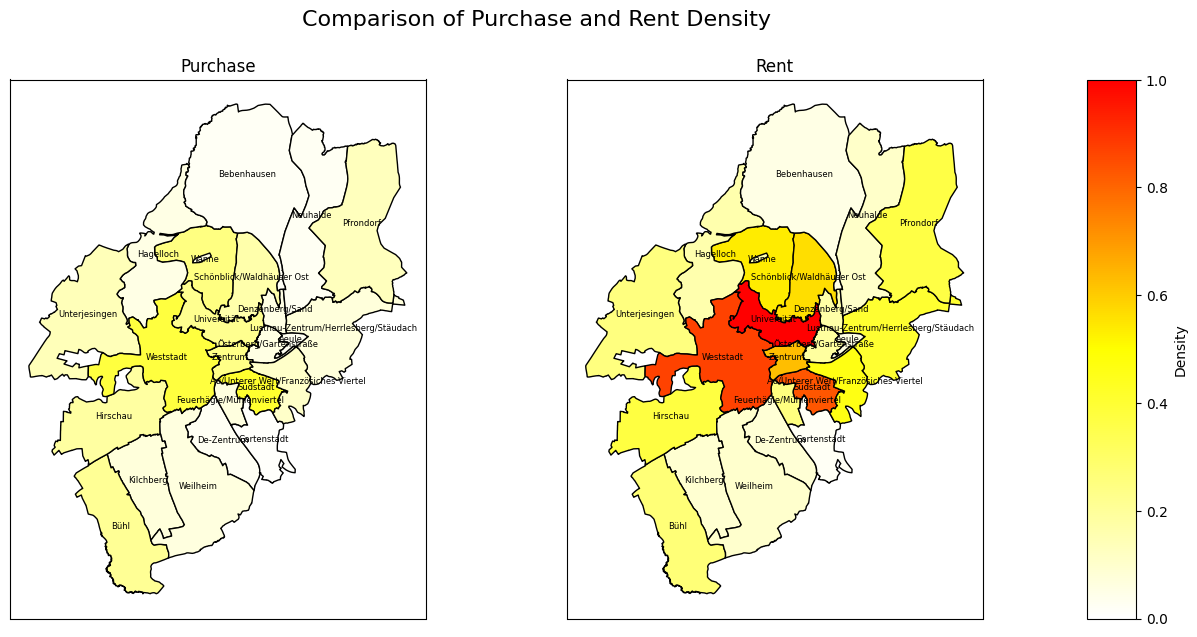

In [36]:
# https://stackoverflow.com/questions/44707213/generating-multiple-heatmaps-with-the-same-gradient

# Plot the GeoDataFrame with a heatmap based on density values using the custom colormap
cmap_white_yellow_red = LinearSegmentedColormap.from_list('white_yellow_red', colors, N=256)

fig, axs = plt.subplots(1, 3, figsize=(15, 7), gridspec_kw={'width_ratios': [10, 10, 1]})

# Plot the GeoDataFrame with heatmaps based on density values using the custom colormap
for ax, density_column, title in zip(axs[:-1], ["count_kauf_normalized", "count_miete_normalized"], ["Purchase", "Rent"]):
    tuebingen_gdf.plot(ax=ax, cmap=cmap_white_yellow_red, edgecolor='black', column=density_column, legend=False, vmin=0, vmax=1) # vmin und vmax machen magic, check nach ob stimmt
    ax.set_title(title)
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])

# Add labels and legend
cax = axs[-1]
sm = plt.cm.ScalarMappable(cmap=cmap_white_yellow_red)
sm.set_array([])  # You need to set an array even if empty
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Density')

for ax, density_column in zip(axs[:-1], ["count_kauf_normalized", "count_miete_normalized"]):
    for idx, row in tuebingen_gdf.iterrows():
        ax.annotate(row["region"], xy=row["geometry"].centroid.coords[0], ha='center', fontsize=6, color='black')

# Set overall title
fig.suptitle('Comparison of Purchase and Rent Density', fontsize=16)

# Adjust layout to prevent clipping of titles


# Show th



# Show the plot
plt.show()



### Check my approach
- normalization
- vmin, vmax

## 2) Median, Average, etc.

In [41]:
df_agg = df_w_loc.groupby(["oadr_u2", "year", "month"]).agg({'kstn_miete_kalt_pqm': ['mean', 'min', 'max', 'std']}).reset_index()

In [48]:
df_agg['year_month'] = df_agg['year'].astype(str) + '-' + df_agg['month'].astype(str).str.zfill(2)

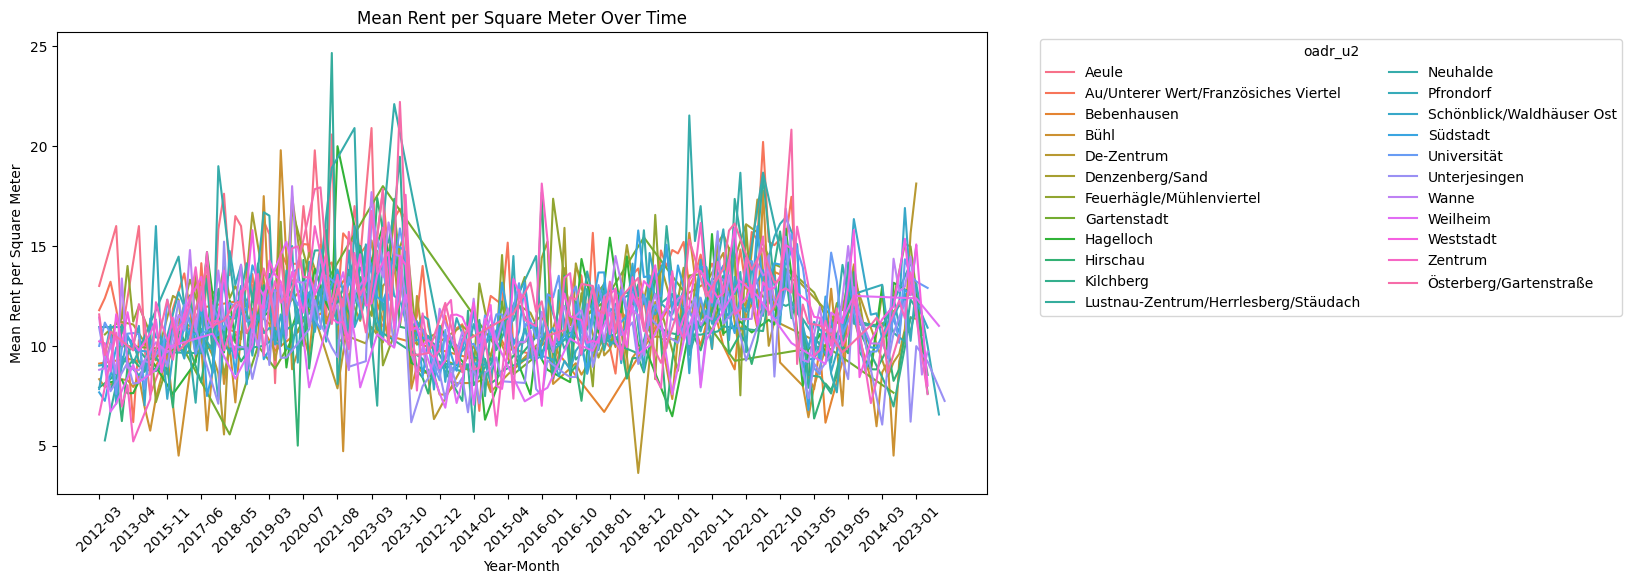

In [53]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=df_agg, x="year_month", y=("kstn_miete_kalt_pqm", "mean"), hue="oadr_u2")
plt.title('Mean Rent per Square Meter Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Mean Rent per Square Meter')
plt.legend(title='oadr_u2', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjust ncol as needed

# Show the plot
plt.xticks(df_agg['year_month'].unique()[::6], rotation=45)
plt.show()

### Difficult task
- We have a lot of oadr_u2, so looking at each one individually is going to be quite messy
- I also dont know how to handle the fact that we have months and years, how to plot that on the x-axis

### possible solutions
- use oadr_u1
- look at specific oadr_u2 
- ?

# IGNORE

In [38]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Replace 'path/to/tuebingen_shapefile.shp' with the actual path to your shapefile
tuebingen_gdf_2 = gpd.read_file("../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp")

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the GeoDataFrame with different colors for different regions, if available
tuebingen_gdf_2.plot(ax=ax, cmap='viridis', edgecolor='black', legend=True)

# Add labels and legend
plt.title('Tübingen, Germany - Regions')
plt.legend()

# Show the plot
plt.show()


DriverError: ../data/tuebingen-regbez-latest-free/gis_osm_buildings_a_free_1.shp: No such file or directory

In [ ]:
tuebingen_gdf_2.columns

In [ ]:
# init_path = "../data/tuebingen-regbez-latest-free/"
# shp_file_paths = ['gis_osm_buildings_a_free_1.shp', 'gis_osm_landuse_a_free_1.shp', 'gis_osm_natural_a_free_1.shp' ,'gis_osm_natural_free_1.shp', 'gis_osm_places_a_free_1.shp', 'gis_osm_places_free_1.shp','gis_osm_pofw_a_free_1.shp', '']

# # Create a list to store GeoDataFrames
# gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# # Create a larger plot with a specified size
# fig, ax = plt.subplots(figsize=(12, 12))

# # Plot each GeoDataFrame with a different color
# for i, gdf in enumerate(gdfs):
#     gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# # Add labels and legend
# plt.title('Combined Plot of Multiple Shapefiles')
# plt.legend()

# # Show the plot
# plt.show()


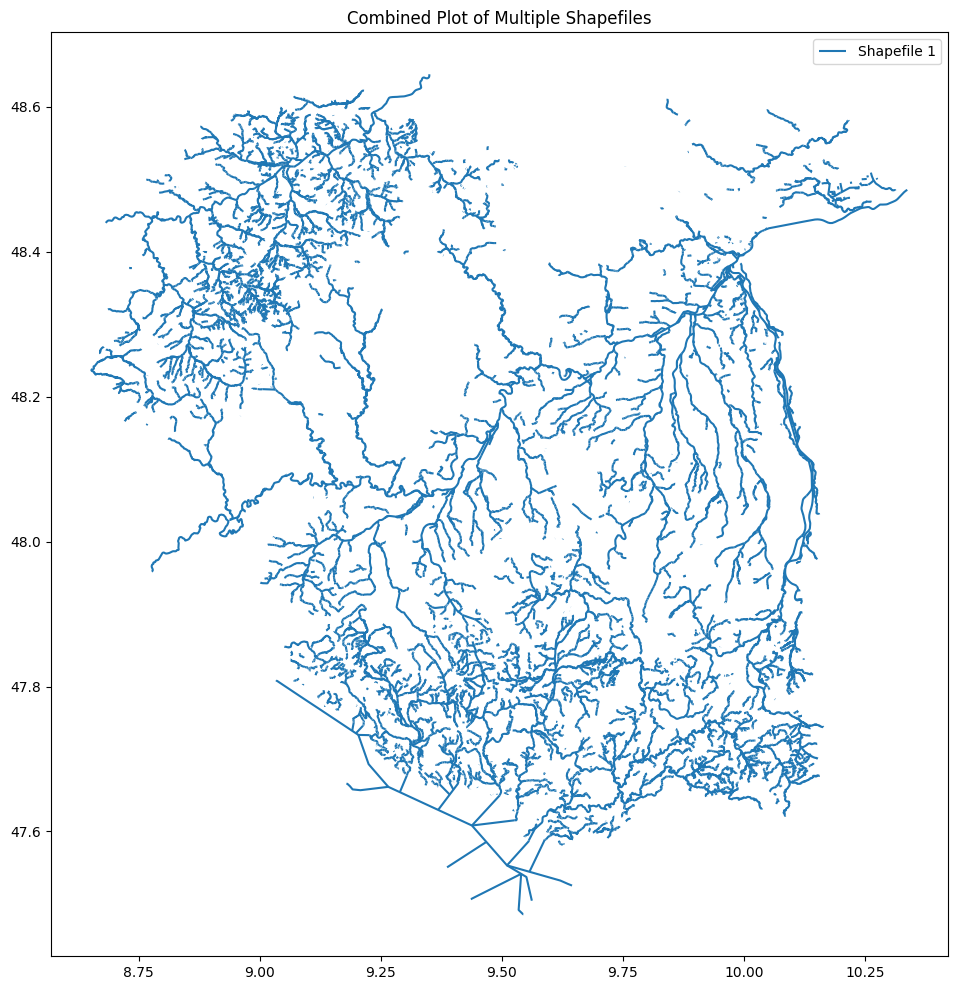

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_waterways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


/var/folders/vx/5fczb1z530gfdp5n8z75tyy80000gn/T/ipykernel_5419/38635465.py:18: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


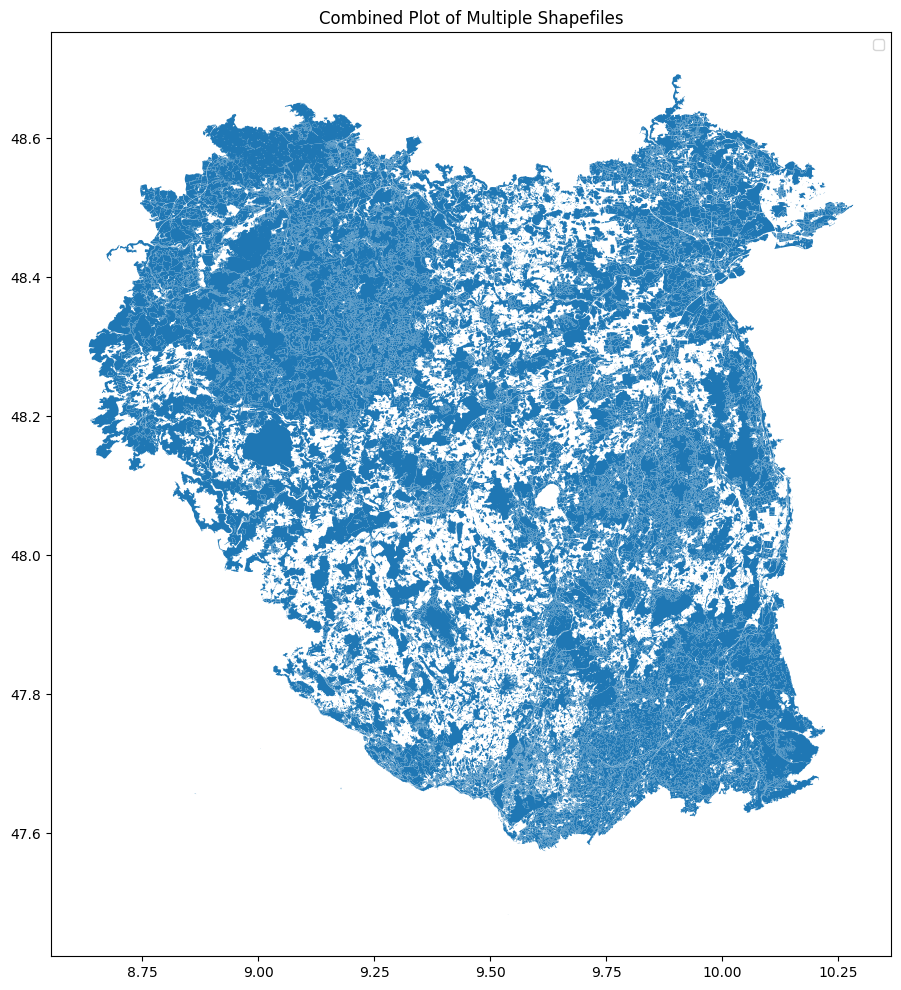

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_landuse_a_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()


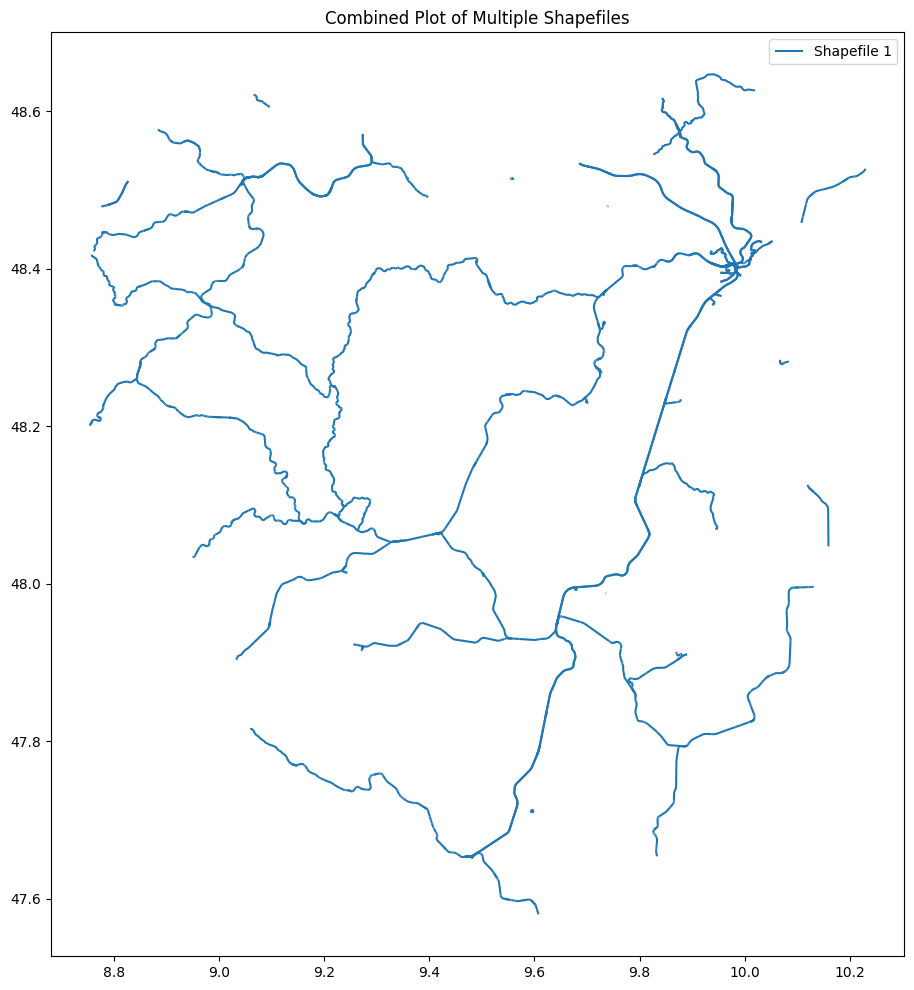

In [ ]:
init_path = "../data/tuebingen-regbez-latest-free/"
shp_file_paths = ['gis_osm_railways_free_1.shp']
# map to every entry in shp_file_paths the init_path
shp_file_paths = [init_path + x for x in shp_file_paths]

# Create a list to store GeoDataFrames
gdfs = [gpd.read_file(shp) for shp in shp_file_paths]

# Create a larger plot with a specified size
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with a different color
for i, gdf in enumerate(gdfs):
    gdf.plot(ax=ax, label=f'Shapefile {i + 1}')

# Add labels and legend
plt.title('Combined Plot of Multiple Shapefiles')
plt.legend()

# Show the plot
plt.show()
